In [1]:
import os
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers
from datetime import datetime
from PIL import Image
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import mlflow
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score

In [2]:
#Clear GPU memory and set up the logging of the experiment with mlflow
K.clear_session()
mlflow.set_experiment('jorge_net')


<Experiment: artifact_location='file:///c:/Users/diosdadj/Desktop/Master/Lung%20Cancer%20Project/capstone_project_UB/mlruns/391329452290209277', creation_time=1685695692186, experiment_id='391329452290209277', last_update_time=1685695692186, lifecycle_stage='active', name='jorge_net', tags={}>

In [3]:
dataset_name = 'private_combined'
batch_size = 32

In [4]:
image_size = (255, 255)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_name,
    validation_split=0.15,
    subset="training",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_name,
    validation_split=0.15,
    subset="validation",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


Found 2791 files belonging to 3 classes.
Using 2373 files for training.
Found 2791 files belonging to 3 classes.
Using 418 files for validation.


In [5]:
# Obtain the number of samples
num_train_samples = 0
for images, labels in train_ds:
    num_train_samples += images.shape[0]

num_val_samples = 0
for images, labels in val_ds:
    num_val_samples += images.shape[0]



In [6]:
input_shape = (255, 255, 3)

model=models.Sequential()

model.add(layers.Rescaling(scale = 1./255, offset=0.0, input_shape=input_shape))
model.add(layers.Input(input_shape))


#Para el dataset publico no hago augmentation porque ya esta hecho
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))
model.add(layers.RandomZoom(0.2))
model.add(layers.RandomContrast(0.2))
model.add(layers.RandomTranslation(0.2, 0.2)) 



model.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=256, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=512, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


# Add flatten layer
model.add(layers.Flatten())

# Add dense/dropout layers + activation functions

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation = 'softmax'))

adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

# plot_model(model, to_file='model.png', show_shapes=True,  rankdir='LR')




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 255, 255, 3)       0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 255, 255, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 255, 255, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 255, 255, 3)       0

In [7]:
num_params = model.count_params()
print("Number of parameters:", num_params)


Number of parameters: 13675363


In [8]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'


In [9]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath_model,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_freq="epoch",
save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='auto', verbose = 1, )

In [10]:
mlflow.end_run()

In [11]:
# Start an MLflow run
mlflow.start_run()

mlflow.set_experiment('jorgenet_project_capstone')

# Log the name of the dataset
mlflow.log_param("dataset_name", dataset_name)

# Log the number of samples in the dataset
#   mlflow.log_param("num_samples_train", num_train_samples)
#   mlflow.log_param("num_samples_train", num_val_samples)

epochs = 80
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback]
)
 
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

#Logging parameters
mlflow.log_param("epochs", epochs)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("parameters", num_params)


#Logging metrics
mlflow.log_metric("val_loss", loss)
mlflow.log_metric("val_accuracy", accuracy)



Epoch 1/80
75/75 [==============================] - 44s 335ms/step - loss: 1.1038 - accuracy: 0.3333 - val_loss: 1.0957 - val_accuracy: 0.3780
Epoch 2/80
75/75 [==============================] - 22s 284ms/step - loss: 1.0938 - accuracy: 0.3582 - val_loss: 1.0781 - val_accuracy: 0.3923
Epoch 3/80
75/75 [==============================] - 22s 282ms/step - loss: 1.0647 - accuracy: 0.4252 - val_loss: 0.9848 - val_accuracy: 0.5191
Epoch 4/80
75/75 [==============================] - 22s 292ms/step - loss: 1.0910 - accuracy: 0.4067 - val_loss: 1.0940 - val_accuracy: 0.3780
Epoch 5/80
75/75 [==============================] - 24s 303ms/step - loss: 1.1030 - accuracy: 0.3418 - val_loss: 1.0919 - val_accuracy: 0.3780
Epoch 6/80
75/75 [==============================] - 23s 297ms/step - loss: 1.0954 - accuracy: 0.3578 - val_loss: 1.0864 - val_accuracy: 0.3301
Epoch 7/80
75/75 [==============================] - 29s 379ms/step - loss: 1.0869 - accuracy: 0.3633 - val_loss: 1.1012 - val_accuracy: 0.2919

In [12]:
#Guardo el modelo en la última epoch. Esto 
model.save(folder_date + '/modelo_entrenado.h5')


In [13]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [14]:
folder_date + "/accuracy.png"

'old_models/2023_06_26-10_10_15_PM/accuracy.png'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


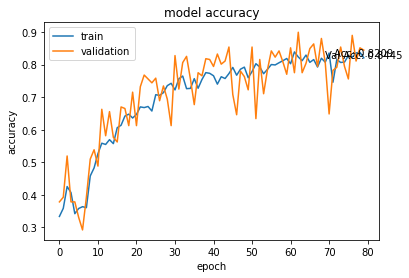

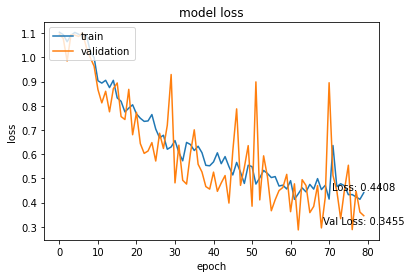

In [15]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], 
         f"Acc: {history.history['accuracy'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], 
         f"Val Acc: {history.history['val_accuracy'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/loss.png")
plt.show()


Preguntas, cómo puedo gestionar datos que vienen de dos distribuciones distintas?



# This is a section to evaluate the model on te test data

[0, 2, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

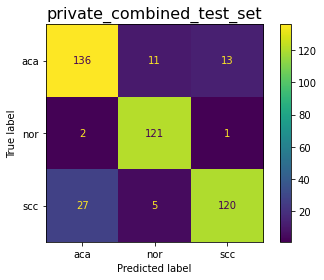

Precision: 0.8658633922913876
Recall: 0.8646788990825688
Accuracy: 0.8646788990825688


In [20]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []

label_mapping = {
    'aca': 0,
    'nor': 1,
    'scc': 2
}


directory = "private_combined_test_set"
for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(255,255))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)

    prediction = model.predict(x)
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca' in filename or 'lungaca' in filename:
        true_labels.append(0)
    elif 'scc' in filename or 'lungscc' in filename:
        true_labels.append(2)
    elif 'nor' in filename or 'lungn' in filename:
        true_labels.append(1)
   
    

    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

mlflow.log_metric("Precision", precision)
mlflow.log_metric("Recall", recall)
mlflow.log_metric("Accuracy", accuracy)

mlflow.end_run()



#Predice mal en las muestras de Henar. Veremos con el nuevo dataset, pero quizá haya que hacer un training con peso Opciones:

Undersample the larger distribution: randomly remove examples from the larger distribution until it matches the size of the smaller one.

Oversample the smaller distribution: randomly duplicate examples from the smaller distribution until it matches the size of the larger one.

Data augmentation: generate new examples from the smaller distribution using techniques like rotation, flipping, or zooming.

Use class weights: adjust the loss function of your CNN to assign higher weights to the smaller distribution so that it receives more emphasis during training.

Fine-tuning: you could use a pre-trained model to initialize the weights and only fine-tune the last few layers to fit the imbalanced data.

1. Domain shift
2. 

[2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


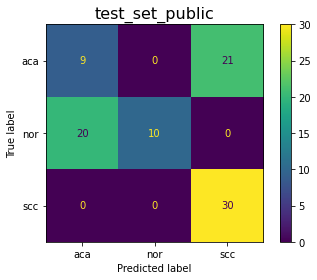

Precision: 0.6328600405679513
Recall: 0.5444444444444444
Accuracy: 0.5444444444444444


In [19]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []

label_mapping = {
    'aca': 0,
    'nor': 1,
    'scc': 2
}


directory = "test_set_public"
for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(255,255))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)

    prediction = model.predict(x)
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca' in filename or 'lungaca' in filename:
        true_labels.append(0)
    elif 'scc' in filename or 'lungscc' in filename:
        true_labels.append(2)
    elif 'nor' in filename or 'lungn' in filename:
        true_labels.append(1)
   
    

    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

mlflow.log_metric("Precision", precision)
mlflow.log_metric("Recall", recall)
mlflow.log_metric("Accuracy", accuracy)

mlflow.end_run()